In [4]:
from multiprocessing.pool import Pool 
from synthesizer import audio
from functools import partial
from itertools import chain
from pathlib import Path
from utils import logmmse
from tqdm import tqdm
import numpy as np
import librosa

In [5]:
def preprocess_audios(datasets_root, out_dir, n_processes, 
                           skip_existing, hparams, pairs):
    # Gather the input directories
    
    print("\n  Using data from:  " + datasets_root)
    
    # Create the output directories for each output file type
    out_dir.joinpath("mels").mkdir(exist_ok=True)
    out_dir.joinpath("audio").mkdir(exist_ok=True)
    
    # Create a metadata file
    metadata_fpath = out_dir.joinpath("train.txt")
    metadata_file = metadata_fpath.open("a" if skip_existing else "w", encoding="utf-8")

    #print(speaker_dirs)
    func = partial(preprocess_speaker, out_dir=out_dir, skip_existing=skip_existing, 
                   hparams=hparams, datasets_root=datasets_root)
    job = Pool(n_processes).imap(func, pairs)
    for speaker_metadata in tqdm(job, "Proprocess", len(pairs), unit="speakers"):
        for metadatum in speaker_metadata:
            metadata_file.write("|".join(str(x) for x in metadatum) + "\n")
    metadata_file.close()

    # Verify the contents of the metadata file
    with metadata_fpath.open("r", encoding="utf-8") as metadata_file:
        metadata = [line.split("|") for line in metadata_file]
    mel_frames = sum([int(m[4]) for m in metadata])
    timesteps = sum([int(m[3]) for m in metadata])
    sample_rate = hparams.sample_rate
    hours = (timesteps / sample_rate) / 3600
    print("The dataset consists of %d utterances, %d mel frames, %d audio timesteps (%.2f hours)." %
          (len(metadata), mel_frames, timesteps, hours))
    print("Max input length (text chars): %d" % max(len(m[5]) for m in metadata))
    print("Max mel frames length: %d" % max(int(m[4]) for m in metadata))
    print("Max audio timesteps length: %d" % max(int(m[3]) for m in metadata))

In [6]:
def preprocess_speaker(speaker_dir, out_dir: Path, skip_existing: bool, hparams, datasets_root):
    metadata = []
    wav_texts = list( (datasets_root + x[0] + '/' + x[1], x[2]) for x in speaker_dir)
    wavs = []
    texts = []
    wav_paths = []
    for wav_path, text in wav_texts:
        wav = split_on_silences(wav_path, hparams)
        wavs.append(wav)
        texts.append(text)
        wav_paths.append(wav_path)
    assert len(wav_paths) == len(wavs) == len(texts)
    for i, (wav, text) in enumerate(zip(wavs, texts)):
            metadata.append(process_utterance(wav, text, out_dir, wav_paths[i].split('/')[-1], 
                                            skip_existing, hparams))
    return [m for m in metadata if m is not None]



In [7]:
def split_on_silences(wav_fpath, hparams):
    # Load the audio waveform
    wav, _ = librosa.load(wav_fpath + '.wav', hparams.sample_rate)
    if hparams.rescale:
        wav = wav / np.abs(wav).max() * hparams.rescaling_max
    
    return wav

In [8]:
def process_utterance(wav, text, out_dir, basename, 
                      skip_existing, hparams):
    ## FOR REFERENCE:
    # For you not to lose your head if you ever wish to change things here or implement your own
    # synthesizer.
    # - Both the audios and the mel spectrograms are saved as numpy arrays
    # - There is no processing done to the audios that will be saved to disk beyond volume  
    #   normalization (in split_on_silences)
    # - However, pre-emphasis is applied to the audios before computing the mel spectrogram. This
    #   is why we re-apply it on the audio on the side of the vocoder.
    # - Librosa pads the waveform before computing the mel spectrogram. Here, the waveform is saved
    #   without extra padding. This means that you won't have an exact relation between the length
    #   of the wav and of the mel spectrogram. See the vocoder data loader.
    
    
    # Skip existing utterances if needed
    mel_fpath = out_dir.joinpath("mels", "mel-%s.npy" % basename)
    wav_fpath = out_dir.joinpath("audio", "audio-%s.npy" % basename)
    if skip_existing and mel_fpath.exists() and wav_fpath.exists():
        return None
    
    # Skip utterances that are too short
    if len(wav) < hparams.utterance_min_duration * hparams.sample_rate:
        return None
    
    # Compute the mel spectrogram
    mel_spectrogram = audio.melspectrogram(wav, hparams).astype(np.float32)
    mel_frames = mel_spectrogram.shape[1]
    
    # Skip utterances that are too long
    if mel_frames > hparams.max_mel_frames and hparams.clip_mels_length:
        return None
    
    # Write the spectrogram, embed and audio to disk
    np.save(mel_fpath, mel_spectrogram.T, allow_pickle=False)
    np.save(wav_fpath, wav, allow_pickle=False)
    
    # Return a tuple describing this training example
    return wav_fpath.name, mel_fpath.name, "embed-%s.npy" % basename, len(wav), mel_frames, text

## Preprocess audios parallelly

In [9]:
batch_size=200
pairs = []

# format in metadata.csv
# spk|wav_name|text

with open('datasets/vctk/metadata.csv') as f:
    subpairs = []
    begin = True
    for line in f.readlines():
        subpairs.append(line.strip().split('|'))
        if len(subpairs) % batch_size == 0 and not begin:
            pairs.append(subpairs)
            subpairs = []
            
        begin = False
        
    if len(subpairs) > 0:
        pairs.append(subpairs)
    

In [10]:
from synthesizer.hparams import hparams
from pathlib import Path

# rootpath is the path to the wav files
rootpath = "datasets/vctk/wavs/"

# the path to store features, including audio and mel-spectrogram
outpath = Path("datasets/vctk").joinpath("synthesizer")
outpath.mkdir(exist_ok=True, parents=True)

preprocess_audios(rootpath, outpath, 16, True, hparams, pairs)


  Using data from:  datasets/vctk/wavs/


Proprocess: 100%|██████████| 221/221 [01:51<00:00,  1.98speakers/s]

The dataset consists of 30617 utterances, 6264070 mel frames, 1249113766 audio timesteps (21.69 hours).
Max input length (text chars): 186
Max mel frames length: 1073
Max audio timesteps length: 214400


## Distribution of the dataset
According to the utterance_min_duration set in hparams.py, more than 10, 000 utterances from VCTK dataset would be ignored.

108 speakers are used for training and testing


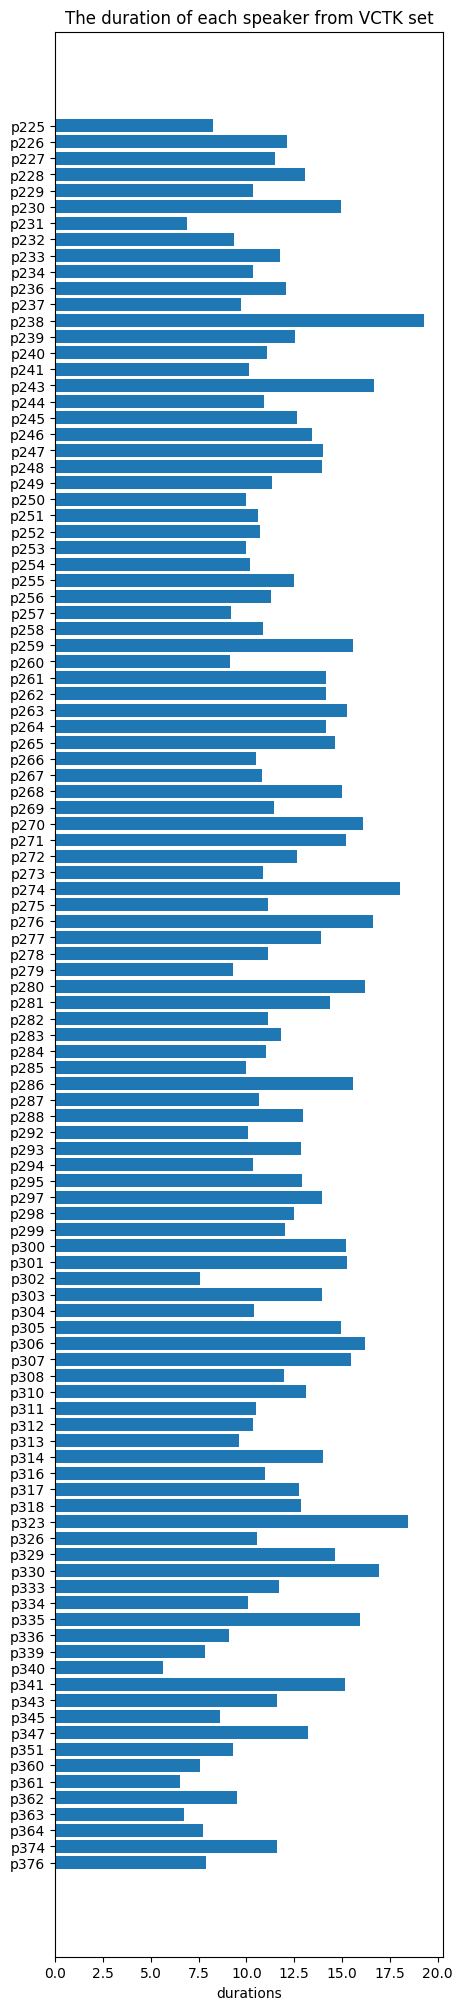

In [27]:
from synthesizer.hparams import hparams
import matplotlib.pyplot as plt
%matplotlib inline

spk2utts = {}
with open('datasets/vctk/synthesizer/train.txt') as metadata_file:
    for line in metadata_file:
        items = line.strip().split("|")
        spk = items[0].replace('audio-', '').split('_')[0]
        if spk not in spk2utts.keys():
            spk2utts[spk] = []
        spk2utts[spk].append(int(items[3]))

spks = list(spk2utts.keys())
len_in_min = [sum(spk2utts[i]) / hparams.sample_rate / 60 for i in spks]
print('%d speakers are used for training and testing' % len(spks))
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(5, 25))

y_pos = np.arange(len(spks))


ax.barh(y_pos, len_in_min, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(spks)
ax.invert_yaxis() 
ax.set_xlabel('durations')
ax.set_title('The duration of each speaker from VCTK set')

plt.show()


# split the data into training testing and validation set

In [29]:
! mv datasets/vctk/synthesizer/train.txt datasets/vctk/synthesizer/all.txt

In [30]:
utts = [line.strip() for line in open('datasets/vctk/synthesizer/all.txt', 'r').readlines()]
spk_dict = {}

for u in utts:
    spk = u.split('-')[1].split('_')[0]
    assert spk[0] == 'p'
    if spk not in spk_dict.keys():
        spk_dict[spk] = []
    spk_dict[spk].append(u)

spk2num = [(spk, len(spk_dict[spk])) for spk in spk_dict.keys()]
spk2num.sort(key=lambda x:x[1])
test_set = spk2num[:8]
training_set = spk2num[8:]

train_wf = open('datasets/vctk/synthesizer/train.txt', 'w')
test_wf = open('datasets/vctk/synthesizer/test.txt', 'w')
val_wf = open('datasets/vctk/synthesizer/val.txt', 'w')

for spk, _ in training_set:
    for utt in spk_dict[spk][:8]:
        val_wf.write(utt + '\n')
    for utt in spk_dict[spk][8:]:
        train_wf.write(utt + '\n')
        
for spk, _ in test_set:
    for utt in spk_dict[spk]:
        test_wf.write(utt + '\n')
        
train_wf.close()
test_wf.close()
val_wf.close()

# Next step, speaker embedding extraction, use deep_speaker/get_gvector.ipynb to obtain speaker embedding